In [1]:
import os
import boto3

import re
import copy
import time
from time import gmtime, strftime
from sagemaker import get_execution_role
role = get_execution_role()
region = boto3.Session().region_name
bucket='sagemaker-mjw1' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data
bucket_path = 'https://s3-{}.amazonaws.com/{}'.format(region,bucket) # The URL to access the bucket

In [2]:
%%time
import pickle, gzip, urllib.request, json
import numpy as np
# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz","mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 896 ms, sys: 273 ms, total: 1.17 s
Wall time: 2.19 s


This is a 5


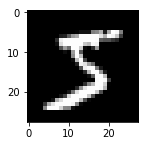

This is a 0


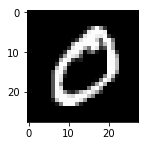

This is a 4


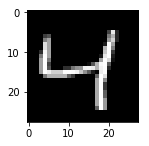

This is a 1


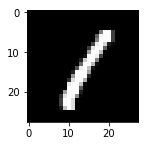

This is a 9


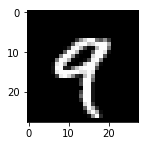

This is a 2


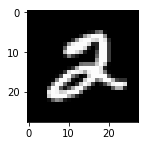

This is a 1


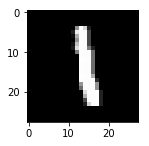

This is a 3


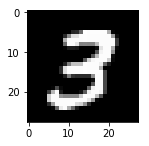

This is a 1


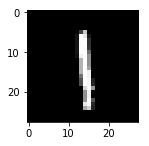

This is a 4


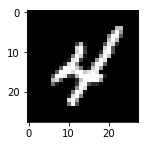

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)
for i in range(0, 10):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

In [4]:
import struct
import io
import csv
import boto3

def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test',test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape,data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        np.savetxt('data.csv', examples, delimiter=',')
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://sagemaker-mjw1/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://sagemaker-mjw1/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://sagemaker-mjw1/sagemaker/xgboost-mnist/test/examples


In [5]:
!ls

data.csv  lost+found  mnist.pkl.gz  MW001.ipynb  mw002.ipynb  Untitled Folder


In [6]:
import sagemaker 

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

In [7]:
### whats in my bucket
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)
for file in my_bucket.objects.all():
    print(file.key)

sagemaker/xgboost-mnist/test/examples
sagemaker/xgboost-mnist/train/examples
sagemaker/xgboost-mnist/validation/examples


In [8]:
#Ensure that the train and validation data folders generated above are reflected in the "InputDataConfig" parameter below.
common_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": bucket_path + "/"+ prefix + "/xgboost"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m4.xlarge",
        "VolumeSizeInGB": 5
    },
    "HyperParameters": {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "silent":"0",
        "objective": "multi:softmax",
        "num_class": "10",
        "num_round": "10"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": bucket_path + "/"+ prefix+ '/train/',
                    "S3DataDistributionType": "FullyReplicated"
        }
    },
        "ContentType": "text/csv",
        "CompressionType": "None"
    },
    {
        "ChannelName": "validation",
        "DataSource": {
        "S3DataSource": {
        "S3DataType": "S3Prefix",
        "S3Uri": bucket_path + "/"+ prefix+ '/validation/',
        "S3DataDistributionType": "FullyReplicated"
            }
        },
        "ContentType": "text/csv",
        "CompressionType": "None"
        }
    ]
}

In [10]:
#training job params
training_job_name = 'xgboost-mnist' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Job name is:", training_job_name)
training_job_params = copy.deepcopy(common_training_params)
training_job_params['TrainingJobName'] = training_job_name
training_job_params['ResourceConfig']['InstanceCount'] = 1

Job name is: xgboost-mnist2020-01-27-10-38-11


In [36]:
training_job_params

{'AlgorithmSpecification': {'TrainingImage': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
  'TrainingInputMode': 'File'},
 'RoleArn': 'arn:aws:iam::644921076874:role/service-role/AmazonSageMaker-ExecutionRole-20200123T162944',
 'OutputDataConfig': {'S3OutputPath': 'https://s3-us-east-2.amazonaws.com/sagemaker-mjw1/sagemaker/xgboost-mnist/xgboost'},
 'ResourceConfig': {'InstanceCount': 1,
  'InstanceType': 'ml.m4.xlarge',
  'VolumeSizeInGB': 5},
 'HyperParameters': {'max_depth': '5',
  'eta': '0.2',
  'gamma': '4',
  'min_child_weight': '6',
  'silent': '0',
  'objective': 'multi:softmax',
  'num_class': '10',
  'num_round': '10'},
 'StoppingCondition': {'MaxRuntimeInSeconds': 86400},
 'InputDataConfig': [{'ChannelName': 'train',
   'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
     'S3Uri': 'https://s3-us-east-2.amazonaws.com/sagemaker-mjw1/sagemaker/xgboost-mnist/train/',
     'S3DataDistributionType': 'FullyReplicated'}},
   'ContentTyp

In [37]:
%%time
region = boto3.Session().region_name
sm = boto3.Session().client('sagemaker')
sm.create_training_job(**training_job_params) #### start a training job
###training_job_name = 'xgboost-mnist' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']

print(status)

sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=training_job_name)
status = sm.describe_training_job(TrainingJobName=training_job_name)['TrainingJobStatus']

print("Training job ended with status: " + status)

if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=training_job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

InProgress
Training job ended with status: Completed
CPU times: user 142 ms, sys: 3.16 ms, total: 145 ms
Wall time: 6min


In [38]:
### You now have a trained model. Amazon SageMaker stores the resulting artifacts in your S3 bucket as a tar.gz file
    
### whats in my bucket
s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)
for file in my_bucket.objects.all():
    print(file.key)


sagemaker/xgboost-mnist/test/examples
sagemaker/xgboost-mnist/train/examples
sagemaker/xgboost-mnist/validation/examples
sagemaker/xgboost-mnist/xgboost/xgboost-mnist2020-01-27-10-38-11/output/model.tar.gz


In [58]:
model_name = training_job_name + '-mod'

info = sm.describe_training_job(TrainingJobName=training_job_name)

model_data = info['ModelArtifacts']['S3ModelArtifacts']

print(model_data)

primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}
create_model_response = sm.create_model(ModelName = model_name,ExecutionRoleArn = role, PrimaryContainer = primary_container)
print(create_model_response['ModelArn'])

https://s3-us-east-2.amazonaws.com/sagemaker-mjw1/sagemaker/xgboost-mnist/xgboost/xgboost-mnist2020-01-27-10-38-11/output/model.tar.gz
arn:aws:sagemaker:us-east-2:644921076874:model/xgboost-mnist2020-01-27-10-38-11-mod


In [62]:
primary_container

{'Image': '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
 'ModelDataUrl': 'https://s3-us-east-2.amazonaws.com/sagemaker-mjw1/sagemaker/xgboost-mnist/xgboost/xgboost-mnist2020-01-27-10-38-11/output/model.tar.gz'}

In [70]:
endpoint_config_name = 'DEMO-XGBoostEndpointConfig-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

print(endpoint_config_name)

create_endpoint_config_response = sm.create_endpoint_config(EndpointConfigName = endpoint_config_name, ProductionVariants=[{
    'InstanceType':'ml.t2.medium',
    'InitialVariantWeight':1,
    'InitialInstanceCount':1,
    'ModelName':model_name,
    'VariantName':'AllTraffic'}])
print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-XGBoostEndpointConfig-2020-01-27-11-49-57
Endpoint Config Arn: arn:aws:sagemaker:us-east-2:644921076874:endpoint-config/demo-xgboostendpointconfig-2020-01-27-11-49-57


In [71]:
%%time
import time
endpoint_name = 'DEMO-XGBoostEndpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)
create_endpoint_response = sm.create_endpoint(EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name)

print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)
while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

print("Arn: " + resp['EndpointArn'])

print("Status: " + status)

DEMO-XGBoostEndpoint-2020-01-27-11-50-12
arn:aws:sagemaker:us-east-2:644921076874:endpoint/demo-xgboostendpoint-2020-01-27-11-50-12
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-east-2:644921076874:endpoint/demo-xgboostendpoint-2020-01-27-11-50-12
Status: InService
CPU times: user 142 ms, sys: 3.9 ms, total: 146 ms
Wall time: 8min 1s
